In [56]:
import uuid
import lightgbm as lgb
from scipy import special
import numpy as np
import pandas as pd
from collections import OrderedDict
from functools import lru_cache 
from datetime import date, datetime, timedelta
from zenquant.trader.database import get_database
from zenquant.trader.constant import Interval
from zenquant.trader.object import  OrderData, TradeData, BarData, TickData
from zenquant.ctastrategy.base import (
    STOPORDER_PREFIX,
    StopOrder,
    StopOrderStatus,
    INTERVAL_DELTA_MAP
)
from zenquant.trader.constant import (
    Status,
    Direction,
    Offset,
    Exchange
)
import gym
from zenquant.trader.utility import  round_to
from zenquant.feed.data import BarDataFeed,TickDataFeed 
from zenquant.feed.portfolio import PortfolioDataStream,NetPortfolioDataStream
from zenquant.env.action import ContinueAction 
from zenquant.env.observer import Observer
from zenquant.env.reward import Reward 
from zenquant.env.stopper import Stopper
from zenquant.env.informer import Informer
from zenquant.env.renender import BarRenderer
from zenquant.utils.get_indicators_info import (
    get_bar_level_indicator_info,
    get_tick_level_indicator_info
)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)

class ContinueEnv(gym.Env):
    """
    A trading environment made for use with Gym-compatible reinforcement
    learning algorithms with continue actions.
    Parameters
    ----------
    """
    def __init__(self):
        self.clock_step = 0 
        self.if_discrete = False
        self.agent_id = 0    ## updated by agent 
        self.env_num  = 0    ## updated by agent 
        self.target_return = 10 
        self.env_name = "ContinueEnv"
        self.episode_id = 0
        self.tick: TickData
        self.bar: BarData
        self.datetime = None
        self.last_price = 6000  ##division by zero
        self.interval = None
        self.min_step = 250

        self.history_data = []
        #history 
        self.history_action = 0
        self.history_pnl = 0

        self.stop_order_count = 0
        self.stop_orders = {}
        self.active_stop_orders = {}

        self.limit_order_count = 0
        self.limit_orders = {}
        self.active_limit_orders = {}

        self.trade_count = 0
        self.trades = OrderedDict()
    def on_init(self,**kwargs):
        '''
        init basic components  of environments 
        read data and load data 
        '''
        ##parameters for environments

        self.gateway_name = kwargs.get("gateway_name","CryptoBacktest")
        self.mode = kwargs.get('mode',"bar") 
        self.vt_symbol = kwargs.get("vt_symbol", "BTCUSDT.BINANCE")
        self.interval = Interval( kwargs.get("interval","1m"))
        self.min_step = kwargs.get("min_step",250)
        self.symbol = kwargs.get("symbol", "BTC/USDT")
        self.exchange= kwargs.get("exchange",Exchange.BINANCE) 

        self.start = kwargs.get("start", datetime(2021, 9, 1))
        self.end = kwargs.get("end", datetime.now())
        ##parmaeters for environments' components
        ##portfolio
        self.MarginLevel= kwargs.get("MarginLevel", 1)
        self.risk_free = kwargs.get("risk_free", 0)
        self.capital =kwargs.get("capital", 100000)
        self.commission_rate = kwargs.get("commission_rate",0.0)
        self.slippage_rate = kwargs.get("slippage_rate ",0.0)
        ##Action 
        self.action_dim = kwargs.get("action_dim",1) 
        self.pricetick = kwargs.get("pricetick", 0.01)
        self.min_volume = kwargs.get("min_volume", 0.001)
        self.min_trade_balance = kwargs.get("min_trade_balance", 5)
        self.limit_total_margin_rate = kwargs.get("limit_total_margin_rate", 0.5)
        self.available_change_percent= kwargs.get("available_change_percent", 0.5)
        self.skip_mode = kwargs.get("skip_mode", "sma") 
        self.sma_window = kwargs.get("sma_window", 10)
        self.atr_window = kwargs.get("atr_window", 14) 
        self.boll_window = kwargs.get("boll_window", 18)
        self.boll_dev = kwargs.get("boll_dev", 3.4)
        self.holding_pos_mode = kwargs.get("holding_pos_mode", "net")
        self.use_stop = kwargs.get("use_stop", False)
        ##Observer 
        self.pos_info_scale = kwargs.get("pos_info_scale", 2**-7)
        self.indicator_info_scale = kwargs.get("indicator_info_scale", 2**-8)
        self.history_action_scale = kwargs.get("history_action_scale", 2**-7)
        self.history_pnl_scale = kwargs.get("history_pnl_scale", 2**-8)
        self.state_dim= kwargs.get("state_dim", 3)
        self.windows_size = kwargs.get("windows_size", 5) 
        self.indicator_windows_list = kwargs.get("indicator_windows_list",[10,20,40,80])
        ##Rewarder 
        self.lag_window = kwargs.get("lag_window", 5)  
        self.extra_reward = kwargs.get("extra_reward", 0.001) 
        self.survive_reward_scale = kwargs.get("survive_reward_scale", 0.001) 
        self.reward_mode = kwargs.get("reward_mode", "differential_sharpe_ratio") 
        ##Stopper  and Informer
        self.max_allowed_loss = kwargs.get("max_allowed_loss", 0.05) 
        ##traning params
        self.profit_stop_rate = kwargs.get("profit_stop_rate", 1)
        self.loss_stop_rate = kwargs.get("loss_stop_rate", -0.5) 
        self.threshold = kwargs.get("threshold",0.43)
        ##Renender(by **kwargs)
        
        ##load data  to history_data
        self.load_data() 
        self.max_step= len(self.history_data) -1 
        #update datafeed and update indicators' info 
        if self.mode == "bar":
            self.datafeed = BarDataFeed(len(self.history_data))
            for idx,bar in enumerate(self.history_data):
                self.datafeed.update_by_index(idx,bar) 
            self.indicator_array = get_bar_level_indicator_info(self.datafeed,self.indicator_windows_list)
            self.atr_array = self.datafeed.atr(self.atr_window,array = True)
            self.sma_array = self.datafeed.sma(self.sma_window,array = True)
            self.boll_up,self.boll_down = self.datafeed.boll(self.boll_window,self.boll_dev,array = True)
        elif self.mode == "tick":
            self.datafeed = TickDataFeed(len(self.history_data))
            for idx,tick  in enumerate(self.history_data):
                self.datafeed.update_by_index(idx,tick) 
            self.indicator_array = get_tick_level_indicator_info(self.datafeed,self.indicator_windows_list)
            self.atr_array = self.datafeed.atr(self.atr_window,array = True)
            self.sma_array = self.datafeed.sma(self.sma_window,array = True)
            self.boll_up,self.boll_down = self.datafeed.boll(self.boll_window,self.boll_dev,array = True)
        else:
            raise NotImplementedError  
        ##创建组件

        if self.holding_pos_mode == "net":
            self.state_dim= len(self.indicator_array) + 5
        else:
            self.state_dim= len(self.indicator_array) + 9
            ##component
        if self.holding_pos_mode == "net":
            self.portfolio = NetPortfolioDataStream(self)
        else:
            self.portfolio = PortfolioDataStream(self)
        self.action = ContinueAction(self)
        self.observer = Observer(self.state_dim,self.windows_size)
        self.rewarder = Reward(reward_mode=self.reward_mode)
        self.stopper = Stopper(self.max_allowed_loss)
        self.informer = Informer() 
        self.renderer = BarRenderer()

        ##check if min_step is ok
        self.indicator_info = np.array([item[self.min_step] for item in self.indicator_array])
        while np.isnan(self.indicator_info).any():
            self.min_step += 1
            self.indicator_info = np.array([item[self.min_step] for item in self.indicator_array])
        ##update  to min_step 
        for i in range(self.min_step):
            self.portfolio.step()

        self.clock_step = self.min_step
        self.portfolio.clock_step = self.min_step
        self.action.clock_step = self.min_step
        self.observer.clock_step = self.min_step
        self.rewarder.clock_step = self.min_step
        self.stopper.clock_step = self.min_step
        self.informer.clock_step = self.min_step
        if self.mode == "bar":
            self.last_price = self.datafeed.close_array[self.clock_step]
        elif self.mode == "tick":
            self.last_price = self.datafeed.last_price_array[self.clock_step]
        self.portfolio.occupy_rate = 0 
        if self.holding_pos_mode == "net":
            self.portfolio.pos_occupy_rate = 0
            self.portfolio.pos_avgprice = self.last_price 
            self.pos_info =  np.array([self.portfolio.occupy_rate,
            abs(self.portfolio.pos)>self.min_volume,
            1.0-self.portfolio.pos_avgprice/self.last_price])
        else:
            self.portfolio.long_pos_occupy_rate = 0
            self.portfolio.short_pos_occupy_rate = 0 
            self.portfolio.long_pos_avgprice = self.last_price 
            self.portfolio.short_pos_avgprice = self.last_price
            self.pos_info = np.array([self.portfolio.long_pos_occupy_rate ,
                                  self.portfolio.short_pos_occupy_rate,
                                  self.portfolio.occupy_rate,     #long+short+locked 
                                  self.portfolio.long_pos>self.min_volume,
                                  self.portfolio.short_pos>self.min_volume,
                                  1.0-self.portfolio.long_pos_avgprice/self.last_price,
                                  self.portfolio.short_pos_avgprice/self.last_price-1.0])   

        self.indicator_info = np.array([item[self.clock_step] for item in self.indicator_array])
        ## update info  for agent 
        self.pos_info = self.pos_info * self.pos_info_scale 
        self.pos_info = np.hstack([self.pos_info,self.history_action,self.history_pnl])
        self.indicator_info = self.indicator_info * self.indicator_info_scale
        self.init_observation = self.observer.observe(self.indicator_info,self.pos_info).reshape((-1,)) 
        
        ## update info  for agent 
        self.observation_space = self.observer.observation_space
        self.action_space = self.action.action_space 
        
        
        #猜测
        self.pred_threshold = kwargs.get("pred_threshold",0.5)
        self.pos_change_ptr = kwargs.get("pos_change_ptr",0.01)
        self.ml_init_pos = kwargs.get("ml_init_pos",2)
        self.ml_add_pos_ratio = kwargs.get("ml_add_pos_ratio",5)
        self.init_open_volume = round_to(self.ml_init_pos*self.min_volume,self.min_volume)
        self.add_volume = self.ml_add_pos_ratio*self.init_open_volume
        self.prev_enter_price =  self.last_price
        self.prev_enter_pos = 0 
    def load_data(self):
        """"""
        self.output("开始加载历史数据")

        if not self.end:
            self.end = datetime.now()

        if self.start >= self.end:
            self.output("起始日期必须小于结束日期")
            return
        self.history_data.clear()       # Clear previously loaded history data

        # Load 30 days of data each time and allow for progress update
        total_days = (self.end - self.start).days
        progress_days = max(int(total_days / 10), 1)
        progress_delta = timedelta(days=progress_days)
        interval_delta = INTERVAL_DELTA_MAP[self.interval]

        start = self.start
        end = self.start + progress_delta
        progress = 0

        while start < self.end:
            progress_bar = "#" * int(progress * 10 + 1)
            self.output(f"加载进度：{progress_bar} [{progress:.0%}]")

            end = min(end, self.end)  # Make sure end time stays within set range

            if self.mode == "bar":
                data = load_bar_data(
                    self.symbol,
                    self.exchange,
                    self.interval,
                    start,
                    end
                )
            else:
                data = load_tick_data(
                    self.symbol,
                    self.exchange,
                    start,
                    end
                )

            self.history_data.extend(data)

            progress += progress_days / total_days
            progress = min(progress, 1)

            start = end + interval_delta
            end += progress_delta

        self.output(f"历史数据加载完成，数据量：{len(self.history_data)}")

    def step(self):
         ##create pd
        df = pd.DataFrame([])
        df["time"]=self.datafeed.datetime_array
        df["high"]=self.datafeed.high
        df["low"]=self.datafeed.low
        df["open"]=self.datafeed.open
        df["close"]=self.datafeed.close
        df["volume"]=self.datafeed.volume
        df["atr"] = self.atr_array 
        df=self.create_label(df)
        for i in range(len(self.indicator_array)):
            df[str(i)]=self.indicator_array[i]
        return  df
        
        
        
    def create_label(self,df):
        zigzags = []
        ATR_MULTIPILIER=self.boll_dev
        def calc_change_since_pivot(row, key):
            current = row[key]
            last_pivot = zigzags[-1]["Value"]
            if(last_pivot == 0): last_pivot = 1 ** (-100) # avoid division by 0
            perc_change_since_pivot = (current - last_pivot) / abs(last_pivot)
            return perc_change_since_pivot

        def get_zigzag(row, taip=None):
            if(taip == "Peak"): key = "high"
            elif(taip == "Trough"): key = "low"
            else: key = "close"

            return {
                "Time": row["time"],
                "Value": row[key],
                "Type": taip 
            }
        for ix, row in df.iterrows():
            threshold = row['atr'] / row["open"] * ATR_MULTIPILIER
            # handle first point
            is_starting = ix == 0
            if(is_starting):
                zigzags.append(get_zigzag(row))
                continue

            # handle first line
            is_first_line = len(zigzags) == 1
            if(is_first_line):
                perc_change_since_pivot = calc_change_since_pivot(row, "close")

                if(abs(perc_change_since_pivot) >= threshold):
                    if(perc_change_since_pivot > 0):
                        zigzags.append(get_zigzag(row, "Peak"))
                        zigzags[0]["Type"] = "Trough"
                    else: 
                        zigzags.append(get_zigzag(row, "Trough"))
                        zigzags[0]["Type"] = "Peak"
                continue
    
            # handle other lines
            is_trough = zigzags[-2]["Value"] > zigzags[-1]["Value"]
            is_ending = ix == len(df.index) - 1
            last_pivot = float(zigzags[-1]["Value"])
            # based on last pivot type, look for reversal or continuation
            if(is_trough):
                perc_change_since_pivot = calc_change_since_pivot(row, "high")
                is_reversing = (perc_change_since_pivot >= threshold) or is_ending
                is_continuing = row["low"] <= last_pivot
                if (is_continuing): 
                    zigzags[-1] = get_zigzag(row, "Trough")
                elif (is_reversing): 
                    zigzags.append(get_zigzag(row, "Peak"))
            else:
                perc_change_since_pivot = calc_change_since_pivot(row, "low")
                is_reversing = (perc_change_since_pivot <= -threshold) or is_ending
                is_continuing = row["high"] >= last_pivot
                if(is_continuing): 
                    zigzags[-1] = get_zigzag(row, "Peak")
                elif (is_reversing): 
                    zigzags.append(get_zigzag(row, "Trough"))
        zigzags = pd.DataFrame(zigzags)
        zigzags["PrevExt"] = zigzags.Value.shift(2)
        df=zigzags.merge(df,left_on="Time",right_on="time",how="right")
        df.Type = df.Type.map({"Trough":1,"Peak":2})
        df.Type=df.Type.replace(np.nan,0)
        df["PrevExt"] = df["PrevExt"].fillna(method='ffill')
        df["target"] = df["PrevExt"]/df["close"]
        return df
    def backtest(self):
        self.models = [] 
        for i in range(5):
            self.models.append(lgb.Booster(model_file="lightgbmeth_"+str(i)+".txt"))
        for _ in range(self.min_step,self.max_step-1):
            if self.mode == "bar":
                self.last_price = self.datafeed.close_array[self.clock_step]
            elif self.mode == "tick":
                self.last_price = self.datafeed.last_price_array[self.clock_step]
            ## stop profit and loss 
            self.pos = self.portfolio.pos
            self.stop_loss_profit()
                         

    
            self.indicator_info = np.array([item[self.clock_step] for item in self.indicator_array])
            self.ml_decision()
                
            self.clock_step += 1 
            ##更新价格
            if self.mode == "bar":
                self.last_price = self.datafeed.close_array[self.clock_step]
            elif self.mode == "tick":
                self.last_price = self.datafeed.last_price_array[self.clock_step]
            
            if self.mode == "bar":
                func = self.new_bar
            else:
                func = self.new_tick
            func(self.history_data[self.clock_step])

            ##检查爆仓与否并更新收益率等信息，为rewarder和stopper提供信息
            self.portfolio.step()
            
    def stop_loss_profit(self):
        if abs(self.pos) > self.min_volume:
            ##检查ml决策后是否减仓或者加仓 
 
            self.ml_pos_handle()
            
            ##趋势止盈和固定

            if self.pos >0 and self.last_price - self.sma_array[self.clock_step] >2.0*self.atr_array[self.clock_step]:
                close_order = self.sell(self.last_price,abs(self.pos))
                #open_order = self.short(self.last_price, self.init_open_volume )
                self.portfolio.update_by_create_order(close_order )
                #self.portfolio.update_by_create_order(open_order)
            elif self.pos <0 and   self.sma_array[self.clock_step] - self.last_price  >2.0*self.atr_array[self.clock_step]:
                close_order = self.cover(self.last_price,abs(self.pos))
                #open_order = self.buy(self.last_price,  self.init_open_volume )
                self.portfolio.update_by_create_order(close_order )
                #self.portfolio.update_by_create_order(open_order)
                     ##固定止损 
            if  self.portfolio.holding_pnl /self.portfolio.total_margin_occupy < self.loss_stop_rate: 
                self.predict_add_pos = False 
                self.predict_reduce_pos = False 
                if self.pos >0:
                    ##平多开空
                    close_order = self.sell(self.last_price, abs(self.pos))
                    self.output(f'止损多头{self.last_price}@{self.pos}')
                    open_order = self.short(self.last_price, self.add_volume) 
                    self.predict_add_pos = True 
                    self.prev_enter_price = self.last_price 
                    self.prev_enter_pos = self.add_volume
                elif self.pos <0:
                    ##平空开多
                    close_order = self.cover(self.last_price, abs(self.pos)) 
                    self.output(f'止损空头{self.last_price}@{self.pos}')
                    open_order = self.buy(self.last_price, self.add_volume) 
                    self.predict_add_pos = True 
                    self.prev_enter_price = self.last_price 
                    self.prev_enter_pos = self.add_volume
                self.portfolio.update_by_create_order(close_order)
                self.portfolio.update_by_create_order(open_order)
                    
    def ml_pos_handle(self):
        ##区分是
        if self.pos > 0:
                up_percent =  (self.last_price - self.prev_enter_price)/self.prev_enter_price
                if  up_percent > self.pos_change_ptr:
                    self.prev_enter_price = self.last_price
                    self.prev_enter_pos = self.add_volume 
                    order = self.buy(self.last_price,self.prev_enter_pos)
                    self.output(f'继续加仓{self.last_price}@{self.prev_enter_pos }')
                    self.predict_add_pos = True 
                    self.portfolio.update_by_create_order(order)
        else:
                up_percent = (self.prev_enter_price-self.last_price)/self.prev_enter_price 
                if  up_percent > self.pos_change_ptr:
                    self.prev_enter_price = self.last_price
                    self.prev_enter_pos = self.add_volume 
                    order = self.short(self.last_price,self.prev_enter_pos)
                    self.output(f'继续加仓{self.last_price}@{self.prev_enter_pos }')
                    self.predict_add_pos = True 
                    self.portfolio.update_by_create_order(order)
                    
        
                
    def ml_decision(self):
        self.step_orders = []
        siginal=self.predict_siginal(self.indicator_info)
        if siginal == 0:
                self.step_orders = None
        else:
                if siginal == 2: ##peak 
                        if self.pos > self.min_volume: 
                            self.step_orders.append(self.sell(self.last_price,abs(self.pos) ))
                        self.step_orders.append(self.short(self.last_price,self.init_open_volume ))
                        self.prev_enter_price = self.last_price
                        self.prev_enter_pos =self.init_open_volume
                else:
                        if self.pos < -self.min_volume:
                            self.step_orders.append(self.cover(self.last_price,abs(self.pos)))
                        self.step_orders.append(self.buy(self.last_price,self.init_open_volume))
                        self.prev_enter_price = self.last_price
                        self.prev_enter_pos = self.init_open_volume
        if self.step_orders:
                for order in self.step_orders:
                    self.portfolio.update_by_create_order(order)
                    
    def buy(self,price,volume):
        return self.action.send_limit_order(
                            Direction.LONG,
                            Offset.OPEN,
                            price,
                            volume)
    def sell(self,price,volume):
        return self.action.send_limit_order(
                            Direction.SHORT,
                            Offset.CLOSE,
                            price,
                            volume)
    def short(self,price,volume):
        return self.action.send_limit_order(
                            Direction.SHORT,
                            Offset.OPEN,
                            price,
                            volume)
    def cover(self,price,volume):
        return self.action.send_limit_order(
                            Direction.LONG,
                            Offset.CLOSE,
                            price,
                            volume)
    
    def predict_siginal(self,indicator_info) :
        predict=[]
        x=indicator_info.reshape(1,-1) 
        for model in self.models:
            predict.append(softmax(model.predict(x)))
        
        prob=np.mean(predict,axis=0)
        prob_max =np.max(prob)
        ##prob_max to small no trade 
        if prob_max>self.pred_threshold:
            siginal = np.argmax(prob)
        else:
            siginal =0 
        return siginal 
    def new_bar(self, bar: BarData):
        """
        撮合订单，并更新portfolio
        """
        self.bar = bar
        self.datetime = bar.datetime

        self.cross_limit_order()
        self.cross_stop_order()
       

    def new_tick(self, tick: TickData):
        """
        撮合订单，并更新portfolio
        """
        self.tick = tick
        self.datetime = tick.datetime

        self.cross_limit_order()
        self.cross_stop_order()
    def cross_limit_order(self):
        """
        Cross limit order with last bar/tick data.
        """
        if self.mode == "bar":
            long_cross_price = self.bar.low_price
            short_cross_price = self.bar.high_price
            long_best_price = self.bar.open_price
            short_best_price = self.bar.open_price
        else:
            long_cross_price = self.tick.ask_price_1
            short_cross_price = self.tick.bid_price_1
            long_best_price = long_cross_price
            short_best_price = short_cross_price

        for order in list(self.active_limit_orders.values()):
            # Push order update with status "not traded" (pending).
            if order.status == Status.SUBMITTING:
                order.status = Status.NOTTRADED

            # Check whether limit orders can be filled.
            long_cross = (
                order.direction == Direction.LONG
                and order.price >= long_cross_price
                and long_cross_price > 0
            )

            short_cross = (
                order.direction == Direction.SHORT
                and order.price <= short_cross_price
                and short_cross_price > 0
            )

            if not long_cross and not short_cross:
                continue

            # Push order udpate with status "all traded" (filled).
            order.traded = order.volume
            order.status = Status.ALLTRADED


            if order.vt_orderid in self.active_limit_orders:
                self.active_limit_orders.pop(order.vt_orderid)


            if long_cross:
                trade_price = min(order.price, long_best_price)
                pos_change = order.volume
            else:
                trade_price = max(order.price, short_best_price)
                pos_change = -order.volume

            trade = TradeData(
                symbol=order.symbol,
                exchange=order.exchange,
                orderid=order.orderid,
                tradeid=str(self.trade_count),
                direction=order.direction,
                offset=order.offset,
                price=trade_price,
                volume=order.volume,
                datetime=self.datetime,
                gateway_name=self.gateway_name,
            )

            if self.update_portfolio(trade): ##检查trade有效性，如果有效则更新portfolio
                self.trade_count += 1
                self.trades[trade.vt_tradeid] = trade

    def cross_stop_order(self):
        """
        Cross stop order with last bar/tick data.
        """
        if self.mode == "bar":
            long_cross_price = self.bar.high_price
            short_cross_price = self.bar.low_price
            long_best_price = self.bar.open_price
            short_best_price = self.bar.open_price
        else:
            long_cross_price = self.tick.last_price
            short_cross_price = self.tick.last_price
            long_best_price = long_cross_price
            short_best_price = short_cross_price

        for stop_order in list(self.active_stop_orders.values()):
            # Check whether stop order can be triggered.
            long_cross = (
                stop_order.direction == Direction.LONG
                and stop_order.price <= long_cross_price
            )

            short_cross = (
                stop_order.direction == Direction.SHORT
                and stop_order.price >= short_cross_price
            )

            if not long_cross and not short_cross:
                continue

            # Create order data.
            self.limit_order_count += 1

            order = OrderData(
                symbol=self.symbol,
                exchange=self.exchange,
                orderid=str(self.limit_order_count),
                direction=stop_order.direction,
                offset=stop_order.offset,
                price=stop_order.price,
                volume=stop_order.volume,
                traded=stop_order.volume,
                status=Status.ALLTRADED,
                gateway_name=self.gateway_name,
                datetime=self.datetime
            )

            self.limit_orders[order.vt_orderid] = order

            # Create trade data.
            if long_cross:
                trade_price = max(stop_order.price, long_best_price)
                pos_change = order.volume
            else:
                trade_price = min(stop_order.price, short_best_price)
                pos_change = -order.volume


            trade = TradeData(
                symbol=order.symbol,
                exchange=order.exchange,
                orderid=order.orderid,
                tradeid=str(self.trade_count),
                direction=order.direction,
                offset=order.offset,
                price=trade_price,
                volume=order.volume,
                datetime=self.datetime,
                gateway_name=self.gateway_name,
            )


            # Update stop order.
            stop_order.vt_orderids.append(order.vt_orderid)
            stop_order.status = StopOrderStatus.TRIGGERED

            if stop_order.stop_orderid in self.active_stop_orders:
                self.active_stop_orders.pop(stop_order.stop_orderid)


            if self.update_portfolio(trade): ##检查trade有效性，如果有效则更新portfolio
                self.trade_count += 1
                self.trades[trade.vt_tradeid] = trade
    def update_portfolio(self,trade):
        '''
        检查trade有效性，并更新portfolio
        '''
        ##限制一下trade_volume 小数点计算问题
        if trade.offset == Offset.CLOSE:
            if self.holding_pos_mode == "net":
                trade.volume = min(trade.volume,abs(self.portfolio.pos))
            else:
                if trade.direction == Direction.LONG: 
                    trade.volume = min(trade.volume,self.portfolio.short_pos)
                ##平多
                elif trade.direction == Direction.SHORT:
                    trade.volume = min(trade.volume,self.portfolio.long_pos)
        trade_effect = True 
        self.portfolio.update_by_trade(trade)
        return trade_effect
                                
    def reset(self):
        """
        reset variables and start another backtesting
        """
        self.episode_id = str(uuid.uuid4())
        self.clock_step = 0 
        self.tick: TickData
        self.bar: BarData
        self.datetime = None
        self.last_price = 60000   
        #history 
        self.history_action = [0]
        self.history_pnl = [0] 

        self.stop_order_count = 0
        self.stop_orders = {}
        self.active_stop_orders = {}

        self.limit_order_count = 0
        self.limit_orders = {}
        self.active_limit_orders = {}

        self.trade_count = 0
        self.trades = OrderedDict()

        self.portfolio.reset()
        self.action.reset()
        self.observer.reset()
        self.rewarder.reset()
        self.stopper.reset()
        self.informer.reset()
        self.renderer.reset()
        
        for i in range(self.min_step):
            self.portfolio.step()
        
        self.clock_step = self.min_step
        self.portfolio.clock_step = self.min_step
        self.action.clock_step = self.min_step
        self.observer.clock_step = self.min_step
        self.rewarder.clock_step = self.min_step
        self.stopper.clock_step = self.min_step
        self.informer.clock_step = self.min_step
        if self.mode == "bar":
            self.last_price = self.datafeed.close_array[self.clock_step]
        elif self.mode == "tick":
            self.last_price = self.datafeed.last_price_array[self.clock_step]
        self.portfolio.occupy_rate = 0 
        if self.holding_pos_mode == "net":
            self.portfolio.pos_occupy_rate = 0
            self.portfolio.pos_avgprice = self.last_price 
            self.pos_info =  np.array([self.portfolio.occupy_rate,
            abs(self.portfolio.pos)>self.min_volume,
            1.0-self.portfolio.pos_avgprice/self.last_price])
        else:
            self.portfolio.long_pos_occupy_rate = 0
            self.portfolio.short_pos_occupy_rate = 0 
            self.portfolio.long_pos_avgprice = self.last_price 
            self.portfolio.short_pos_avgprice = self.last_price
            self.pos_info = np.array([self.portfolio.long_pos_occupy_rate ,
                                  self.portfolio.short_pos_occupy_rate,
                                  self.portfolio.occupy_rate,     #long+short+locked 
                                  self.portfolio.long_pos>self.min_volume,
                                  self.portfolio.short_pos>self.min_volume,
                                  1.0-self.portfolio.long_pos_avgprice/self.last_price,
                                  self.portfolio.short_pos_avgprice/self.last_price-1.0])  
        self.indicator_info = np.array([item[self.clock_step] for item in self.indicator_array])
        ## update info  for agent 
        self.pos_info = self.pos_info * self.pos_info_scale 
        self.pos_info = np.hstack([self.pos_info,self.history_action,self.history_pnl])
        self.indicator_info = self.indicator_info * self.indicator_info_scale
        self.init_observation = self.observer.observe(self.indicator_info,self.pos_info).reshape((-1,)) 
        ## update info  for agent 
        self.action_space = self.action.action_space 
        ## 返回开始计算的min_step时刻Observe的状态
        return self.init_observation

    def render(self, **kwargs) -> None:
        """Renders the environment."""
        self.renderer.render(self, **kwargs)

    def save(self) -> None:
        """Saves the rendered view of the environment."""
        self.renderer.save()

    def close(self) -> None:
        """Closes the environment."""
        self.renderer.close()
    def output(self, msg) -> None:
        """
        Output message of backtesting engine.
        """
        print(f"{datetime.now()}\t{msg}") 
@lru_cache(maxsize=999)
def load_bar_data(
    symbol: str,
    exchange: Exchange,
    interval: Interval,
    start: datetime,
    end: datetime
):
    """"""
    database = get_database()

    return database.load_bar_data(
        symbol, exchange, interval, start, end
    )


@lru_cache(maxsize=999)
def load_tick_data(
    symbol: str,
    exchange: Exchange,
    start: datetime,
    end: datetime
):
    """"""
    database = get_database()

    return database.load_tick_data(
        symbol, exchange, start, end
    )



In [57]:




test_env= ContinueEnv()
config={
    "gateway_name":"CryptoContinue",
    'mode':"bar",
    "vt_symbol":"ETHUSDT.BINANCE",
    "interval":"1m",
    "symbol": "ETHUSDT",
    "exchange":Exchange.BINANCE,
    "min_step":100,
    "start":datetime(2022,1,8),
    "end":datetime(2022, 1, 10),
    "MarginLevel":10,
    "risk_free":0,
    "capital":100,
    "commission_rate":0.0002,
    "slippage_rate":0,
    "pricetick": 0.01,
    "min_volume":0.001,
    "min_trade_balance":5,
    "limit_total_margin_rate":0.5,
    "available_change_percent":0.05,
    "skip_mode":"",
    "sma_window":20,
    "atr_window":20,
    "boll_window":20,
    "boll_dev":1.414,
    "holding_pos_mode":"net",
    "use_stop":False,
    "pos_info_scale ":1,
    "indicator_info_scale":1,
    "history_action_scale ":1,
    "history_pnl_scale":1,
    "windows_size": 1,
    "indicator_windows_list":[6,36,192,720],
    "lag_window":20,
    "extra_reward":0,
    "reward_mode":'differential_sharpe_ratio',
    "max_allowed_loss":0.5,
    
    "loss_stop_rate":-0.01,
    ##马丁
    "pred_threshold":0.51,
    "pos_change_ptr":0.001,
    "ml_add_pos_ratio":14,
    "ml_init_pos":2,
    ##DQN params 
    "learning_rate":2**-15,
    "batch_size": 2**11,
    "gamma":  0.97,
    "seed":312,
    "net_dim": 2**9,
    "worker_num":4,
    "threshold":0.5,
    "reward_scale":1,
    "target_step": 10000, #collect target_step, then update network
    "eval_gap": 30  #used for evaluate, evaluate the agent per eval_gap seconds
}


In [58]:
for i in range(len(max_down_list)):
    print(max_down_list[i],pnl_list[i])

In [ ]:
MarginLevel_list =[10,15,20,25]
max_down_list = []
pnl_list=[]
for item in MarginLevel_list :
    config["MarginLevel"] = item 
    test_env.on_init(**config)
    test_env.backtest() 
   # max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    max_down_list.append(test_env.portfolio.max_drawdown_rate )
    pnl_list.append(test_env.portfolio.total_pnl_rate)
    test_env.reset()

In [ ]:
boll_window_list =[10,15,20,25,30,35,40]
max_down_list = []
pnl_list=[]
for item in boll_window_list :
    config["atr_window"] = item 
    test_env.on_init(**config)
    test_env.backtest() 
   # max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    max_down_list.append(test_env.portfolio.max_drawdown_rate )
    pnl_list.append(test_env.portfolio.total_pnl_rate)
    test_env.reset()

In [ ]:
boll_dev_list =[1.6,1.8,2.0,2.2,2.4]
max_down_list = []
pnl_list=[]
for item in boll_dev_list :
    config["boll_dev"] = item 
    test_env.on_init(**config)
    test_env.backtest() 
   # max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    max_down_list.append(test_env.portfolio.max_drawdown_rate )
    pnl_list.append(test_env.portfolio.total_pnl_rate)
    test_env.reset()

In [59]:
test_env.on_init(**config)

2022-01-10 14:55:42.295935	开始加载历史数据
2022-01-10 14:55:42.296180	加载进度：# [0%]
2022-01-10 14:55:42.423295	加载进度：###### [50%]
2022-01-10 14:55:42.558645	历史数据加载完成，数据量：2881


In [64]:
test_env.reset()

array([ 1.06953314e-02,  2.19736046e-04,  5.15521880e-09,  3.74905102e-05,
        1.04661008e-04, -1.14554337e-05,  1.40369315e-03,  0.00000000e+00,
        2.39626844e-03, -9.90374312e-04,  1.50274462e-03,  1.00000000e+00,
        2.03225996e-02, -1.62115848e-02,  3.86524548e-03,  1.04198246e-03,
        1.74280035e+01,  1.74266404e+01,  1.20235010e+02,  6.16487525e+01,
        7.32224434e+01,  6.66221629e+01,  4.90876725e+01,  1.00000000e+02,
        6.66221629e+01,  1.00000000e+02,  1.00000000e+02,  3.61558072e-01,
       -4.40047974e-01,  4.78146780e-01,  5.21853220e-01, -4.37064391e-02,
        1.60809989e-04,  2.14767679e-08,  1.33559943e-04,  1.60549639e-04,
        1.32605323e-04,  1.45118875e-03,  2.27754850e-03,  6.55146666e-03,
       -5.76104174e-03, -1.46837832e-04,  7.42038217e-01, -2.69552755e-02,
       -5.55480151e-02,  4.76920222e-03,  7.97502469e-03,  1.83836699e+01,
        2.01258876e+01,  4.20894564e+01,  4.66211710e+01,  5.85219662e+01,
        6.68183358e+01,  

In [34]:
print(test_env.portfolio.max_drawdown_rate)
print(test_env.portfolio.total_pnl_rate)

0.07298210074660946
0.538854197368955


In [ ]:
0.07298210074660946
0.538854197368955

In [ ]:
0.03409052658097181
0.46067646463999923

In [ ]:
0.32500189889515585
-0.19766527018976773

In [ ]:
pred_threshold_list = [0.43,0.45,0.47,0.51,0.53,0.55]
for rate in pred_threshold_list:
    test_env.loss_stop_rate = -0.05
    test_env.pred_threshold = rate
    test_env.backtest() 
   # max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

In [ ]:
ml_add_pos_ratio_list = [6,8,10,12,14]
for rate in ml_add_pos_ratio_list:
    test_env.ml_init_pos = 2
    test_env.ml_add_pos_ratio=  rate
    test_env.add_volume = test_env.ml_add_pos_ratio*test_env.init_open_volume
    test_env.loss_stop_rate = -0.05
    test_env.backtest() 
   # max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

In [66]:
for i in range(len(max_down_list)):
    print(max_down_list[i],pnl_list[i])

0.018492726839999987 0.6716638449200008
0.013052551079999688 0.6651242328399997
0.025081806887370335 -0.018914872439999043
0.013746025665223092 -0.008383926759999554
0.02127177849642607 -0.013189884039998958


In [65]:
loss_per =[-0.02,-0.03,-0.04,-0.05]
pos_change_ptr_list = [0.001,0.002]
max_down_list = []
pnl_list=[]
for rate in loss_per:
    for pos_change_ptr in pos_change_ptr_list:
        test_env.loss_stop_rate = rate
        test_env.pos_change_ptr = pos_change_ptr
        test_env.backtest() 
        max_down_list.append(test_env.portfolio.max_drawdown_rate )
        pnl_list.append(test_env.portfolio.total_pnl_rate)
        test_env.reset()

2022-01-10 15:10:42.916515	止损空头3207.29@-0.002
2022-01-10 15:10:43.016256	止损多头3200.18@0.028
2022-01-10 15:10:43.174692	继续加仓3194.75@0.028
2022-01-10 15:10:43.737293	继续加仓3198.48@0.028
2022-01-10 15:10:44.221905	止损多头3190.23@0.032
2022-01-10 15:10:44.588678	继续加仓3192.51@0.028
2022-01-10 15:10:44.703066	继续加仓3196.18@0.028
2022-01-10 15:10:44.786690	止损多头3186.2@0.058
2022-01-10 15:10:45.082488	止损多头3175.31@0.002
2022-01-10 15:10:46.136816	止损多头3147.92@0.002
2022-01-10 15:10:46.272565	继续加仓3155.71@0.028
2022-01-10 15:10:46.410047	继续加仓3148.78@0.028
2022-01-10 15:10:46.521956	止损空头3155.69@-0.03
2022-01-10 15:10:46.569776	止损多头3148.27@0.028
2022-01-10 15:10:46.578799	止损多头3143.64@0.028
2022-01-10 15:10:46.587408	止损空头3152.77@-0.114
2022-01-10 15:10:46.604564	止损多头3146.33@0.058
2022-01-10 15:10:46.631389	止损空头3155.88@-0.058
2022-01-10 15:10:46.775726	止损空头3167.99@-0.002
2022-01-10 15:10:46.823506	继续加仓3158.63@0.028
2022-01-10 15:10:46.831917	继续加仓3155.33@0.028
2022-01-10 15:10:46.905542	止损多头3153.91@0.002
2022-01

KeyboardInterrupt: 

In [ ]:
pos_change_ptr_list = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009]
for rate in pos_change_ptr_list:
    test_env.pos_change_ptr= rate
    test_env.loss_stop_rate = -0.01
    test_env.backtest() 
   # max_down_list.append(test_env.portfolio.max_drawdown_rate )
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

In [23]:
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)

0.1227972798587047
60.540976946520686


In [32]:
profit_stop_rate_list=[0.2,0.4,0.5,0.8,1,1.2]
max_down_list = []
pnl_list = []
test_env.reset()
for profit_stop_rate in profit_stop_rate_list:
    test_env.loss_stop_rate = -0.2
    test_env.profit_stop_rate = profit_stop_rate
    test_env.backtest() 
    max_down_list.append(test_env.portfolio.max_drawdown_rate )
    pnl_list.append(test_env.portfolio.total_pnl_rate)
    print(test_env.portfolio.max_drawdown_rate)
    print(test_env.portfolio.total_pnl_rate)
    test_env.reset()

0.0748869279507974
-0.04442024352000132
0.07287610745611031
-0.04236516588000143
0.07292335547112049
-0.04241345380000141
0.07292335547112049
-0.04241345380000141
0.07292335547112049
-0.04241345380000141
0.07292335547112049
-0.04241345380000141


In [21]:
test_env.trades

OrderedDict([('CryptoContinue.0',
              TradeData(gateway_name='CryptoContinue', symbol='ETHUSDT', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='1', tradeid='0', direction=<Direction.SHORT: '空'>, offset=<Offset.OPEN: '开'>, price=3813.94, volume=0.002, datetime=datetime.datetime(2022, 1, 4, 12, 2, tzinfo=<UTC>))),
             ('CryptoContinue.1',
              TradeData(gateway_name='CryptoContinue', symbol='ETHUSDT', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='2', tradeid='1', direction=<Direction.LONG: '多'>, offset=<Offset.CLOSE: '平'>, price=3823.53, volume=0.002, datetime=datetime.datetime(2022, 1, 4, 12, 24, tzinfo=<UTC>))),
             ('CryptoContinue.2',
              TradeData(gateway_name='CryptoContinue', symbol='ETHUSDT', exchange=<Exchange.BINANCE: 'BINANCE'>, orderid='3', tradeid='2', direction=<Direction.LONG: '多'>, offset=<Offset.OPEN: '开'>, price=3823.53, volume=0.01, datetime=datetime.datetime(2022, 1, 4, 12, 24, tzinfo=<UTC>))),
             ('CryptoC

In [73]:
test_env.reset()
test_env.threshold = 0.4
test_env.loss_stop_rate = -0.13
test_env.profit_stop_rate = 0.5

In [74]:
test_env.backtest()
print(test_env.portfolio.max_drawdown_rate)
print(test_env.portfolio.total_pnl_rate)

0.11692443133715832
1.40829994576503e+22


In [ ]:
max_down_list = []

In [ ]:
test_env.portfolio.net_capital,test_env.portfolio.max_net_capital 

In [ ]:
test_env.portfolio.max_drawdown_rate 

In [6]:
df= test_env.step()

In [7]:
df.Type=df.Type.shift() 

In [8]:
df = df.loc[:len(df)-2]

## 数据分析

In [15]:
import matplotlib.pyplot as plt

In [16]:
test_x = df.iloc[:10]

In [17]:
H=test_x.high.values
L=test_x.low.values
C=test_x.close.values
index=list(test_x.index)

In [18]:
import talib as TA

In [19]:
TA.MAX(df.high,10)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
480956    4782.12
480957    4778.81
480958    4772.52
480959    4772.52
480960    4772.52
Length: 480961, dtype: float64

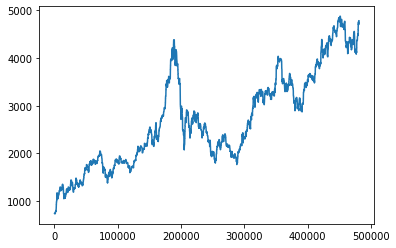

In [20]:
plt.plot(df.index,TA.MAX(df.high,500))

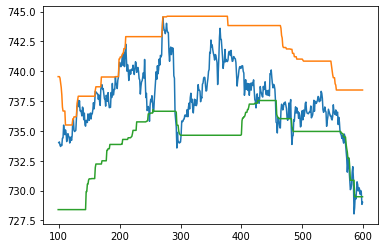

In [21]:
#plt.plot(df.index[:600],TA.MIN(df.low,500)[:600])
#plt.plot(df.index[:600],TA.MAX(df.low,500)[:600])
plt.plot(df.index[100:600],df.close[100:600])
plt.plot(df.index[:600],TA.MAX(df.high,100)[:600])
plt.plot(df.index[:600],TA.MIN(df.high,100)[:600])

## 构建模型

In [35]:
df.Type.value_counts()

0.0    360033
1.0     82784
2.0     82784
Name: Type, dtype: int64

In [9]:
df.columns.to_list()

['Time',
 'Value',
 'Type',
 'PrevExt',
 'time',
 'high',
 'low',
 'open',
 'close',
 'volume',
 'atr',
 'target',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '1

In [10]:
features_columns =[str(i) for i in range(129)]

In [11]:
import copy 
all_feature= copy.deepcopy(features_columns)
all_feature.append("Type")

In [12]:
test_df=df[all_feature]
test_df=test_df.dropna()

In [13]:
test_df["Type"]=test_df["Type"].astype(int)

In [14]:
test_df.Type.value_counts()

0    293581
1     32851
2     32850
Name: Type, dtype: int64

In [15]:
import numpy as np
from scipy import optimize
from scipy import special
import pandas as pd
import numpy as np
from datetime import datetime
import random
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib as TA
import gc
import optuna
from optuna import Trial
from scipy import optimize
from scipy import special
from sklearn.model_selection import TimeSeriesSplit
from scipy.misc import derivative
import seaborn as sns
def sigmoid(x): 
    return 1./(1. +  np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)
def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1,num_class, order='F')
    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten('F'), hess.flatten('F')
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False

In [16]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 2., 3)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 2., 3)

In [17]:



def fit_lgbm(trial, train, val, devices=(0,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    ## import for metric and params search 
    metric= {'multi_error'} 
    params = {
         'objective': 'multiclass',
        #'objective':'binary',
        "num_class":3,
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.01, 0.15),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 10.0),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 10),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        "metric":metric,
        "verbosity": -1,
        "max_bin":15,
        "gpu_use_dp":False,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu'})

    params['seed'] = seed

    early_stop = 1000
    verbose_eval = 1000

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_valid, label=y_valid)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      fobj=focal_loss,
                      feval=eval_error)

    
    # predictions
    #y_pred_valid = np.argmax(model.predict(X_valid, num_iteration=model.best_iteration),axis=1)
    #valid_score = precision_score(y_valid,y_pred_valid,average="macro")
    print('best_score', model.best_score)
    log = {'train_loss': model.best_score['training']['multi_error'],
           'valid_loss': model.best_score['valid_1']['multi_error']}
    return model, log

def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 42
    shuffle = False
    kf = TimeSeriesSplit(n_splits=folds,max_train_size=None)

    X_train = test_df[features_columns]
    y_train = np.array(test_df["Type"])
    print(len(X_train),len(y_train))
    #y_valid_pred_total = np.zeros(X_train.shape[0])
    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, log = fit_lgbm(trial, train_data, valid_data,
                                            num_rounds=5000)
        #y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log['valid_loss']
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return models,valid_score
    else:
        return valid_score

In [18]:
study = optuna.create_study()
study.optimize(objective, n_trials=8)

[I 2022-01-08 03:57:09,665] A new study created in memory with name: no-name-16ae8cfb-d1d1-4f5f-ad07-474976964c2e


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.162052	training's focal_loss: 0.0271643	valid_1's multi_error: 0.169205	valid_1's focal_loss: 0.029083
[2000]	training's multi_error: 0.150062	training's focal_loss: 0.0252012	valid_1's multi_error: 0.165631	valid_1's focal_loss: 0.0284529
[3000]	training's multi_error: 0.141629	training's focal_loss: 0.0238479	valid_1's multi_error: 0.163544	valid_1's focal_loss: 0.0281989
[4000]	training's multi_error: 0.134047	training's focal_loss: 0.0227834	valid_1's multi_error: 0.162508	valid_1's focal_loss: 0.0281032
[5000]	training's multi_error: 0.128185	training's focal_loss: 0.0218842	valid_1's multi_error: 0.161874	valid_1's focal_loss: 0.0280385
Did not meet early stopping. Best iteration is:
[4967]	training's multi_error: 0.127952	training's focal_loss: 0.0219114	valid_1's multi_error: 0.161924	valid_1's focal_loss: 0

[I 2022-01-08 04:12:02,701] Trial 0 finished with value: 0.16192384769539078 and parameters: {'max_depth': 5, 'learning_rate': 0.019118107944095727, 'lambda_l1': 3.6155057741697076, 'lambda_l2': 3.099959512542633, 'bagging_freq': 6, 'bagging_fraction': 0.37829984964836805, 'feature_fraction': 0.3449642478847507}. Best is trial 0 with value: 0.16192384769539078.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0516349	training's focal_loss: 0.0134543	valid_1's multi_error: 0.1583	valid_1's focal_loss: 0.0288532
Early stopping, best iteration is:
[340]	training's multi_error: 0.119735	training's focal_loss: 0.0211214	valid_1's multi_error: 0.158935	valid_1's focal_loss: 0.0278005
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.11973547977689455), ('focal_loss', 0.02112139836445725)]), 'valid_1': OrderedDict([('multi_error', 0.15893453573814295), ('focal_loss', 0.027800459641488712)])})


[I 2022-01-08 04:16:13,906] Trial 1 finished with value: 0.15893453573814295 and parameters: {'max_depth': 6, 'learning_rate': 0.08089209131285997, 'lambda_l1': 0.3099908078779296, 'lambda_l2': 2.882483711014621, 'bagging_freq': 10, 'bagging_fraction': 0.6555068070193032, 'feature_fraction': 0.8988580671115122}. Best is trial 1 with value: 0.15893453573814295.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0729268	training's focal_loss: 0.0154942	valid_1's multi_error: 0.157064	valid_1's focal_loss: 0.0278499
Early stopping, best iteration is:
[535]	training's multi_error: 0.107712	training's focal_loss: 0.0195712	valid_1's multi_error: 0.157214	valid_1's focal_loss: 0.0275469
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.1077118332721018), ('focal_loss', 0.019571164178354406)]), 'valid_1': OrderedDict([('multi_error', 0.15721442885771544), ('focal_loss', 0.027546908280984692)])})


[I 2022-01-08 04:21:04,526] Trial 2 finished with value: 0.15721442885771544 and parameters: {'max_depth': 7, 'learning_rate': 0.07981946744189218, 'lambda_l1': 1.5772628780422915, 'lambda_l2': 2.8661156772694176, 'bagging_freq': 7, 'bagging_fraction': 0.758381292103492, 'feature_fraction': 0.6726578282222221}. Best is trial 2 with value: 0.15721442885771544.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.126131	training's focal_loss: 0.0219346	valid_1's multi_error: 0.162709	valid_1's focal_loss: 0.028136
[2000]	training's multi_error: 0.0926155	training's focal_loss: 0.0176656	valid_1's multi_error: 0.16022	valid_1's focal_loss: 0.0281397
Early stopping, best iteration is:
[1628]	training's multi_error: 0.104055	training's focal_loss: 0.0190453	valid_1's multi_error: 0.160772	valid_1's focal_loss: 0.0280321
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.10405464079356067), ('focal_loss', 0.019045284871075336)]), 'valid_1': OrderedDict([('multi_error', 0.16077154308617234), ('focal_loss', 0.02803205094349917)])})


[I 2022-01-08 04:28:55,852] Trial 3 finished with value: 0.16077154308617234 and parameters: {'max_depth': 10, 'learning_rate': 0.02851926159331343, 'lambda_l1': 0.5845548264969364, 'lambda_l2': 2.1034086710934328, 'bagging_freq': 5, 'bagging_fraction': 0.4151342991012995, 'feature_fraction': 0.33318804004371555}. Best is trial 2 with value: 0.15721442885771544.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.165075	training's focal_loss: 0.0280964	valid_1's multi_error: 0.168921	valid_1's focal_loss: 0.0295257
[2000]	training's multi_error: 0.158779	training's focal_loss: 0.0271179	valid_1's multi_error: 0.168854	valid_1's focal_loss: 0.0293754
[3000]	training's multi_error: 0.154337	training's focal_loss: 0.0264247	valid_1's multi_error: 0.167819	valid_1's focal_loss: 0.0293212
Early stopping, best iteration is:
[2367]	training's multi_error: 0.157376	training's focal_loss: 0.0268394	valid_1's multi_error: 0.167351	valid_1's focal_loss: 0.0293693
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.15737617314050967), ('focal_loss', 0.026839417379256044)]), 'valid_1': OrderedDict([('multi_error', 0.16735136940547762), ('focal_loss', 0.029369258112202125)])})


[I 2022-01-08 04:38:28,740] Trial 4 finished with value: 0.16735136940547762 and parameters: {'max_depth': 2, 'learning_rate': 0.06844228630286331, 'lambda_l1': 1.0925270504719673, 'lambda_l2': 2.6303468151642426, 'bagging_freq': 10, 'bagging_fraction': 0.14913992899050682, 'feature_fraction': 0.8531504055347505}. Best is trial 2 with value: 0.15721442885771544.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.141578	training's focal_loss: 0.0242985	valid_1's multi_error: 0.164696	valid_1's focal_loss: 0.0287421
[2000]	training's multi_error: 0.123643	training's focal_loss: 0.0217356	valid_1's multi_error: 0.16498	valid_1's focal_loss: 0.0293906
Early stopping, best iteration is:
[1001]	training's multi_error: 0.141512	training's focal_loss: 0.0242948	valid_1's multi_error: 0.165197	valid_1's focal_loss: 0.0287417
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.141511639557797), ('focal_loss', 0.02429484389466392)]), 'valid_1': OrderedDict([('multi_error', 0.16519706078824314), ('focal_loss', 0.028741731453079778)])})


[I 2022-01-08 04:44:13,598] Trial 5 finished with value: 0.16519706078824314 and parameters: {'max_depth': 3, 'learning_rate': 0.12418653662710062, 'lambda_l1': 0.791686784297399, 'lambda_l2': 2.2553232307029725, 'bagging_freq': 1, 'bagging_fraction': 0.2525443597400558, 'feature_fraction': 0.32675453413862154}. Best is trial 2 with value: 0.15721442885771544.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.108413	training's focal_loss: 0.0195099	valid_1's multi_error: 0.159519	valid_1's focal_loss: 0.0281003
Early stopping, best iteration is:
[510]	training's multi_error: 0.131275	training's focal_loss: 0.0226716	valid_1's multi_error: 0.159335	valid_1's focal_loss: 0.0278534
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.1312748405196887), ('focal_loss', 0.02267159182664475)]), 'valid_1': OrderedDict([('multi_error', 0.15933533734134936), ('focal_loss', 0.027853403747658444)])})


[I 2022-01-08 04:48:47,462] Trial 6 finished with value: 0.15933533734134936 and parameters: {'max_depth': 4, 'learning_rate': 0.13266832399232262, 'lambda_l1': 2.2361158430105625, 'lambda_l2': 0.5145651856588822, 'bagging_freq': 3, 'bagging_fraction': 0.6714954353142445, 'feature_fraction': 0.5258570044189529}. Best is trial 2 with value: 0.15721442885771544.


359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.150496	training's focal_loss: 0.0251112	valid_1's multi_error: 0.165364	valid_1's focal_loss: 0.0284251
[2000]	training's multi_error: 0.130022	training's focal_loss: 0.0222356	valid_1's multi_error: 0.161824	valid_1's focal_loss: 0.0281365
Early stopping, best iteration is:
[1983]	training's multi_error: 0.130173	training's focal_loss: 0.0222798	valid_1's multi_error: 0.16174	valid_1's focal_loss: 0.0281068
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.13017267292341606), ('focal_loss', 0.022279830342385905)]), 'valid_1': OrderedDict([('multi_error', 0.16174014696058783), ('focal_loss', 0.028106776000714723)])})


[I 2022-01-08 04:57:31,423] Trial 7 finished with value: 0.16174014696058783 and parameters: {'max_depth': 4, 'learning_rate': 0.026073318242827825, 'lambda_l1': 0.244983572921572, 'lambda_l2': 0.2418426017038287, 'bagging_freq': 6, 'bagging_fraction': 0.3527410610871874, 'feature_fraction': 0.5627014540799067}. Best is trial 2 with value: 0.15721442885771544.


In [22]:
study.best_params

{'max_depth': 7,
 'learning_rate': 0.07981946744189218,
 'lambda_l1': 1.5772628780422915,
 'lambda_l2': 2.8661156772694176,
 'bagging_freq': 7,
 'bagging_fraction': 0.758381292103492,
 'feature_fraction': 0.6726578282222221}

In [23]:
params={'max_depth': 7,
 'learning_rate': 0.07981946744189218,
 'lambda_l1': 1.5772628780422915,
 'lambda_l2': 2.8661156772694176,
 'bagging_freq': 7,
 'bagging_fraction': 0.758381292103492,
 'feature_fraction': 0.6726578282222221}

In [24]:
 models0,valid_score = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=0, return_info=True)

359282 359282
train 59882 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.0731605	training's focal_loss: 0.0155125	valid_1's multi_error: 0.156446	valid_1's focal_loss: 0.0279233
Early stopping, best iteration is:
[518]	training's multi_error: 0.109014	training's focal_loss: 0.0197789	valid_1's multi_error: 0.157315	valid_1's focal_loss: 0.0275805
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('multi_error', 0.10901439497678768), ('focal_loss', 0.019778920079535786)]), 'valid_1': OrderedDict([('multi_error', 0.15731462925851702), ('focal_loss', 0.0275805169428295)])})
train 119762 valid 59880
using gpu device_id 0...
training LGB:
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_error: 0.102203	training's focal_loss: 0.0187231	valid_1's multi_error: 0.157365	valid_1's focal_loss: 0.0270347
Early stopping, best ite

In [25]:
for i in range(len(models0)):
    models0[i].save_model("lightgbmeth_"+str(i)+".txt")